# Computer Vision - Project
imports

In [75]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import h5py
import requests
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import tensorflow as tf
import h5py, requests, os
import matplotlib.patches as patches
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization, ZeroPadding2D, GlobalMaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Resizing
from tqdm import tqdm

Constants

In [76]:
#ZIP_PATH = "https://drive.google.com/drive/folders/1jzHYpTwywUYA53nMGHVROSuVO14hEueq?usp=sharing/"
FILE_NAME ="SynthText_train.h5"
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
tf.keras.backend.clear_session()
SIZE=224


In [77]:
def sort_points(points, center):
    # calculate the angle of each point from the center point
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    # sort the points by angle
    sorted_points = points[np.argsort(angles)]
    return sorted_points

In [78]:
def draw_training_curve(history):
	"""
	Draw training curve
	Parameters:
		history - contains loss and accuracy from training
	Returns:
		None
	"""
	plt.figure(1)

	# History for accuracy
	plt.subplot(211)
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	# History for loss
	plt.subplot(212)
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	plt.show()

In [79]:
def draw_points(image, points, color=(255, 0, 0), radius=3):
    # create a copy of the image
    img = image.copy()
    # iterate over the points and draw them on the image
    for point in points:
        cv2.circle(img, tuple(map(int, point)), radius, color, -1)
    return img


In [80]:
def font_to_num(font):
    if font == b'Alex Brush':
        return 0
    elif font == b'Open Sans':
        return 1
    elif font == b'Sansation':
        return 2
    elif font == b'Titillium Web':
        return 3
    else:
        return 4

In [81]:
def num_to_font(font):
    if font == 0:
        return b'Alex Brush'
    elif font == 1:
        return b'Open Sans'
    elif font == 2:
        return b'Sansation'
    elif font == 3:
        return b'Titillium Web'
    else:
        return b'Ubuntu Mono'

In [82]:
def print_label(set, index):
    line = set[index]
    max = np.argmax(line)
    print(num_to_font(max))

In [83]:
def print_font(max):
     print(num_to_font(max))

In [84]:
def print_photo_from_set(set_x, set_y, index, font):
    plt.imshow(set_x[index], cmap='gray')
    plt.show()
    print_font(font)

In [85]:

def prepare_img(img, bbs, index, size = SIZE):
    x1 = int(bbs[0,0,index])
    y1 = int(bbs[1,0,index])
    x2 = int(bbs[0,1,index])
    y2 = int(bbs[1,1,index])
    x3 = int(bbs[0,2,index])
    y3 = int(bbs[1,2,index])
    x4 = int(bbs[0,3,index])
    y4 = int(bbs[1,3,index])
    # calculate bounding rectangle
    top_left_x = max(0, min([x1,x2,x3,x4]))
    top_left_y = max(0, min([y1,y2,y3,y4]))
    bot_right_x = max(0, max([x1,x2,x3,x4]))
    bot_right_y = max(0, max([y1,y2,y3,y4]))

    cropped = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    # _, cropped = cv2.threshold(cropped,127,255,cv2.THRESH_TRIANGLE)
    # print(cropped.shape)
    cropped = tf.image.resize(cropped, (size, size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # cropped = tf.image.rgb_to_grayscale(cropped)
    # # print(cropped.shape)
    cropped = tf.image.convert_image_dtype(cropped, tf.float32)
    # plt.imshow(cropped, cmap='gray')
    # plt.show()
    return cropped

In [86]:
from pathlib import Path
def create_dirs(main_directory):
    Path(main_directory).mkdir(parents=True, exist_ok=True)
    Path(main_directory+'/Alex Brush').mkdir(parents=True, exist_ok=True)
    Path(main_directory+'/Titillium Web').mkdir(parents=True, exist_ok=True)
    Path(main_directory+'/Sansation').mkdir(parents=True, exist_ok=True)
    Path(main_directory+'/Open Sans').mkdir(parents=True, exist_ok=True)
    Path(main_directory+'/Ubuntu Mono').mkdir(parents=True, exist_ok=True)

In [87]:
def get_image_data(db, im):
    img  = db['data'][im][:]
    fonts = db['data'][im].attrs['font']
    txts = db['data'][im].attrs['txt']
    charBBs = db['data'][im].attrs['charBB']
    wordBBs = db['data'][im].attrs['wordBB']
    return img, fonts, txts, charBBs, wordBBs

In [88]:
def is_num_or_letter(inp):
    res= ((inp >= ord('a') and inp <= ord('z')) or (inp >= ord('A') and inp <= ord('Z'))) or (inp>=ord('0') and inp<=ord('9'))
    # print(chr(inp)+"="+str(res))
    return res

In [89]:
def crop_and_save(img, BBs, indx, size, curr_font, im, num, append_not_save=False, folder='main_directory/'):
    cropped = prepare_img(img, BBs, indx, size)
    path = folder+curr_font.decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg' 
    if not append_not_save:
        tf.keras.utils.save_img(path,cropped)
    return cropped

In [90]:
db = h5py.File(FILE_NAME, 'r')

In [91]:
def get_data_set(db, size: int):   
    create_dirs('main_directory')
    im_names = list(db['data'].keys())
    num = 0
    for i in tqdm(range(0, len(im_names)-1)):
        im = im_names[i]
        img  = db['data'][im][:]
        fonts = db['data'][im].attrs['font']
        txts = db['data'][im].attrs['txt']
        charBBs = db['data'][im].attrs['charBB']
        wordBBs = db['data'][im].attrs['wordBB']
        font_indx = 0 
        char_indx = 0
        # print(im)
        for j in range(0, len(txts)):
            cropped = prepare_img(img, wordBBs, j, size)
            path = 'main_directory/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg' 
            # print(path)
            tf.keras.utils.save_img(path,cropped)
            num+=1
            # train_x.append(cropped)
            # train_y.append(font_to_num(fonts[font_indx]))
            
            # plt.imshow(cropped, cmap='gray')
            # plt.show()
            # print(fonts[font_indx])
            for k in range(0, len(txts[j])):
                if(is_num_or_letter(txts[j][k])):
                    cropped = prepare_img(img, charBBs, char_indx, size)
                    path = 'main_directory/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg'
                    # print(path)
                    tf.keras.utils.save_img(path,cropped)
                    num+=1
                    # train_x.append(cropped)
                    # train_y.append(font_to_num(fonts[font_indx]))
                char_indx+=1
                    # plt.imshow(cropped, cmap='gray')
                    # plt.show()
                    # print(fonts[font_indx])
            font_indx += len(txts[j])
    print(num)

In [92]:
from download_h5py_db import download_h5py_db
if not Path("main_directory").exists():
    download_h5py_db()
    get_data_set(db, SIZE)
# train_x, train_y = 

100%|██████████| 997/997 [02:33<00:00,  6.49it/s]

36011


In [93]:
import splitfolders
splitfolders.ratio("main_directory/", # The location of dataset
                   output="main_directory_splitted", # The output location
                   seed=42, # The number of seed
                   ratio=(.8, .1, .1), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

Copying files: 36011 files [00:48, 735.62 files/s]


In [94]:
from keras.preprocessing.image import ImageDataGenerator
def data_augmentation():
    datagen =  ImageDataGenerator(
        horizontal_flip=True, rotation_range=90, fill_mode='reflect', channel_shift_range=0.8,#
         shear_range=15,vertical_flip=False, brightness_range=(0.2, 0.8),# 
     rescale=1/255, dtype='float32'
     #,validation_split=0.25
     )
    # Path('augmented').mkdir(exist_ok=True)
    it = datagen.flow_from_directory('main_directory_splitted/train/', batch_size=18, class_mode='categorical',
    #save_to_dir='augmented',
     shuffle=True, seed=1, keep_aspect_ratio=True)
    datagen_val =  ImageDataGenerator(
     rescale=1/255, dtype='float32'
     )
    val_it = datagen_val.flow_from_directory('main_directory_splitted/val/', batch_size=18, class_mode='categorical',
    #save_to_dir='augmented',
     shuffle=True)
    test_it = datagen_val.flow_from_directory('main_directory_splitted/test/', batch_size=18, class_mode='categorical',
    #save_to_dir='augmented',
     shuffle=True)
    return it, val_it,test_it, datagen

In [95]:
it, val_it,test_it, datagen = data_augmentation()

Found 28806 images belonging to 5 classes.
Found 3599 images belonging to 5 classes.
Found 3606 images belonging to 5 classes.


Found 27011 images belonging to 5 classes.
Found 9000 images belonging to 5 classes.

In [96]:
# datagen.fit(it, augment=True, seed=0.8, rounds=5)

In [97]:
from tensorflow.keras import callbacks
early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

filepath="res/top_model.h5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [early_stopping,checkpoint]

In [98]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GaussianNoise

from keras import regularizers

num_classes = 5
input_size= SIZE

baseModel = tf.keras.applications.ResNet50(include_top=False, classes=num_classes,
                         input_shape=(input_size, input_size, 3),
                        weights='imagenet')
headModel = baseModel.output
headModel = GaussianNoise(0.1)(headModel)
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)    
model.compile(optimizer=tf.keras.optimizers.Adam(0.00003), loss='categorical_crossentropy', metrics=['accuracy'])


In [99]:
def scheduler(epoch, lr):
    # if epoch < 5:
    #     return lr
    # else:
    return lr * 0.1 #tf.math.exp(-0.1)

In [100]:
# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [101]:
# model.fit(X_train, Y_train, batch_size=16, epochs=20)
# datagen.fit(X_train)
# if not os.path.isfile('model_res.h5'):
history = model.fit(it, epochs=20, shuffle=True, validation_data=val_it, verbose=1
            ,callbacks=callbacks_list
            )
# else:
#   model = tf.keras.models.load_model('model_res.h5')

Epoch 1/20
1601/1601 [==============================] - ETA: 0s - loss: 5.4869 - accuracy: 0.3851
Epoch 1: val_loss improved from inf to 4.54289, saving model to res\top_model.h5
1601/1601 [==============================] - 503s 310ms/step - loss: 5.4869 - accuracy: 0.3851 - val_loss: 4.5429 - val_accuracy: 0.4987
Epoch 2/20
1601/1601 [==============================] - ETA: 0s - loss: 3.7034 - accuracy: 0.5552
Epoch 2: val_loss improved from 4.54289 to 2.92659, saving model to res\top_model.h5
1601/1601 [==============================] - 494s 308ms/step - loss: 3.7034 - accuracy: 0.5552 - val_loss: 2.9266 - val_accuracy: 0.6079
Epoch 3/20
1601/1601 [==============================] - ETA: 0s - loss: 2.4269 - accuracy: 0.6188
Epoch 3: val_loss improved from 2.92659 to 1.92568, saving model to res\top_model.h5
1601/1601 [==============================] - 528s 330ms/step - loss: 2.4269 - accuracy: 0.6188 - val_loss: 1.9257 - val_accuracy: 0.6610
Epoch 4/20
1601/1601 [======================

In [102]:
score = model.evaluate(test_it)

201/201 [==============================] - 18s 89ms/step - loss: 0.5132 - accuracy: 0.8242


In [103]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.5132091641426086 / Test accuracy: 0.8241819143295288


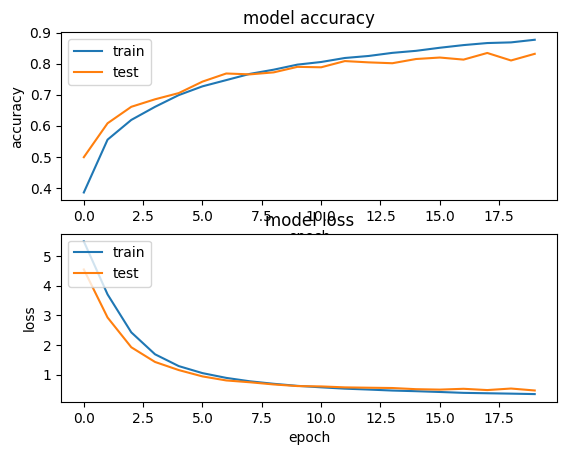

In [104]:
draw_training_curve(history)

In [108]:
# model.save('model_res')

In [ ]:
model = tf.keras.models.load_model('res//top_model.h5')

In [119]:
from sklearn.preprocessing import normalize
create_dirs('test_set')
size=SIZE
im_names = list(db['data'].keys())
num = 0
prediction_arr=[]
test_y = []

for i in tqdm(range(0, int((len(im_names)-1)/4))):
    im = im_names[i]
    img, fonts, txts, charBBs, wordBBs = get_image_data(db, im)
    font_indx = 0 
    char_indx = 0
    curr_font = fonts[font_indx]
    # print(im)
    for j in range(0, int(len(txts)/4)):
        if(j%8==0): 
            test_x = [] 
            cropped = crop_and_save(img, wordBBs, j, size, curr_font, im, num, False, 'test_set/')
            test_x.append(cropped)
            # test_y.append(font_to_num(curr_font))
            num+=1            
            for k in range(0, len(txts[j])):
                # if(is_num_or_letter(txts[j][k])):
                cropped = crop_and_save(img, charBBs, char_indx, size, curr_font, im, num, False, 'test_set/')
                test_x.append(cropped)
                    # test_y.append(font_to_num(curr_font))
                num+=1
                char_indx+=1
            test_x = np.asarray(test_x, dtype=np.float32)
            # # print(test_x)
            reses = model.predict(test_x, verbose=0)
            # # print(reses)
            maxes = np.argmax(reses, axis=1)
            # print(np.bincount(maxes))
            prediction = np.bincount(maxes)
            prediction = np.argwhere(prediction==prediction.max())
            if (len(prediction)>1):
                sum_p = reses.sum(axis=0)
                prediction = sum_p.argmax()

                if(font_to_num(curr_font)!=prediction):
                    # print(sum_p)
                    reses_n = normalize(reses, axis=1, norm='l1')
                    maxes_n = np.argmax(reses_n, axis=1)
                    # print(np.bincount(maxes))
                    prediction = np.bincount(maxes_n)
                    prediction = np.argmax(prediction)
                    if(font_to_num(curr_font)!=prediction):
                        sum_p = np.sum(reses, axis=0)
                        prediction = sum_p.argmax()
                    # # print(reses[0]/np.sum(reses, axis=1)[0])
                    #     print(maxes)
                    # print(prediction)
                    # plt.imshow(test_x[0])
                    # plt.show()
                    # print(prediction)
                    # print(font_to_num(fonts[font_indx]))
            for k in range(0, len(txts[j])):
                test_y.append(font_to_num(fonts[font_indx]))
                prediction_arr.append(prediction.item())
                # print(prediction.item())
            # if(font_to_num(curr_font)!=prediction):
            #     plt.imshow(test_x[0])
            #     plt.show()
            #     print(maxes)
            #     print(reses)
            #     print(prediction)
            #     print(font_to_num(fonts[font_indx]))
            #     print('----------------------')
            # print(num_to_font(prediction))
            # print(test_x)
            # print(str(np.bincount(maxes).argmax())+"-"+str(font_to_num(fonts[font_indx])))
            # print(np.bincount(maxes).argmax())
        else:
            char_indx+=len(txts[j])
        font_indx += len(txts[j])



  1%|          | 2/249 [00:00<00:59,  4.15it/s]

[1 0 3 2]
[0 0 1 0 3]


  2%|▏         | 4/249 [00:00<00:40,  6.05it/s]

[0 0 0 0 2]
[4 0 0 0 0 2 0]


  2%|▏         | 6/249 [00:00<00:26,  9.26it/s]

[4 4 4 4]
[0 0 0 0 4]


  4%|▍         | 10/249 [00:01<00:25,  9.50it/s]

[4 4 4 4 4]
[3 3 3 3]
[2 2 3 2]


  5%|▍         | 12/249 [00:01<00:25,  9.46it/s]

[0 1 0 4]
[0 0 0 0 0 0 0]


  6%|▌         | 14/249 [00:01<00:26,  8.85it/s]

[0 0 0 0]
[4 4 2 4 2 2 0 2 4 0 4 0]


  7%|▋         | 17/249 [00:02<00:25,  9.28it/s]

[3 3 0 0]
[4 4 4 4 4]
[1 1 1 2]


  8%|▊         | 20/249 [00:02<00:24,  9.30it/s]

[4 4 4 4 4 4 4]
[0 0 0 0]
[2 3 2 2 2]


  9%|▉         | 22/249 [00:02<00:26,  8.67it/s]

[0 0 0 0 0 0 0 1]
[2 2 2 2 2 2 4]


 10%|▉         | 24/249 [00:02<00:24,  9.02it/s]

[2 2 2 2]
[4 4 4 2]


 10%|█         | 26/249 [00:03<00:25,  8.73it/s]

[2 4 2 2 2]
[0 0 0 0 0 0]


 11%|█         | 28/249 [00:03<00:28,  7.75it/s]

[4 4 4 4 4 4 4]
[1 3 3 3 3 3 0 3 0 3]


 12%|█▏        | 30/249 [00:03<00:28,  7.76it/s]

[0 0 2 0 0 0 0 2 0]
[3 3 3 3]


 13%|█▎        | 32/249 [00:03<00:29,  7.30it/s]

[0 0 0 0 0 0 0 0 0 0 0 0]
[4 4 0 4 4 0]


 14%|█▎        | 34/249 [00:04<00:27,  7.94it/s]

[4 4 4 0 4 4]
[0 0 0 0]


 15%|█▍        | 37/249 [00:04<00:19, 10.79it/s]

[0 0 0 0 0 0 0]
[4 4 0 0]


 16%|█▋        | 41/249 [00:04<00:14, 14.10it/s]

[4 1 3 1 1 0]
[0 0 0 0]


 17%|█▋        | 42/249 [00:04<00:23,  8.67it/s]


[2 1 2 2 2 1]


KeyboardInterrupt: 

In [ ]:
print(len(prediction_arr))
print(len(test_y))
# test_x = np.asarray(test_x, dtype=np.float32)

837
837


In [ ]:
# y_pred=np.argmax(prediction_arr, axis=1)

In [118]:
from sklearn.metrics import classification_report
labels=['Alex Brush','Open Sans','Sansation','Titillium Web','Ubuntu Mono']
print(classification_report(test_y, prediction_arr, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.75      0.98      0.85       169
    Open Sans       0.86      0.85      0.85       142
    Sansation       0.94      0.77      0.84       208
Titillium Web       0.91      0.82      0.86       158
  Ubuntu Mono       0.96      0.98      0.97       160

     accuracy                           0.88       837
    macro avg       0.88      0.88      0.88       837
 weighted avg       0.89      0.88      0.88       837



In [ ]:
print(len(test_x))

1003


In [ ]:
prediction_arr = model.predict(test_x)

32/32 [==============================] - 4s 105ms/step


In [ ]:
y_pred=np.argmax(prediction_arr, axis=1)
# y_test=np.argmax(test_y_cat, axis=1)

In [ ]:
test_y = np.asarray(test_y, dtype=np.float32)

In [ ]:
test_y_cat = np_utils.to_categorical(test_y, 5)

In [ ]:
# print(test_y)
print(test_y.shape)

(1003,)


In [ ]:
from sklearn.metrics import classification_report
labels=['Alex Brush','Open Sans','Titillium Web','Sansation','Ubuntu Mono']
print(classification_report(test_y, prediction_arr, target_names=labels))

In [ ]:
# for im in test_x:
#     tf.keras.utils.save_img('path',cropped)

In [110]:
dg =  ImageDataGenerator(
     rescale=1/255, dtype='float32',
     )
t = dg.flow_from_directory('test_set', shuffle=False)

Found 1036 images belonging to 5 classes.


In [111]:
model.evaluate(t)

33/33 [==============================] - 7s 150ms/step - loss: 0.4039 - accuracy: 0.8620


[0.40388888120651245, 0.8619691133499146]

In [ ]:
y_pred=np.argmax(prediction_arr, axis=1)

In [ ]:
print(classification_report(test_y, y_pred, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.80      0.93      0.86       204
Titillium Web       0.14      0.12      0.13       195
    Sansation       0.73      0.68      0.70       248
    Open Sans       0.13      0.14      0.13       168
  Ubuntu Mono       0.81      0.82      0.81       188

     accuracy                           0.56      1003
    macro avg       0.52      0.54      0.53      1003
 weighted avg       0.54      0.56      0.55      1003



In [ ]:
datagen_t =  ImageDataGenerator(
     rescale=1/255, dtype='float32'
     )
t_it = datagen_t.flow_from_directory('check_test', batch_size=18, class_mode='categorical',shuffle=False
#save_to_dir='augmented',
    )

Found 3850 images belonging to 5 classes.


In [ ]:
score = model.evaluate(t_it)

214/214 [==============================] - 15s 68ms/step - loss: 0.6127 - accuracy: 0.7730


In [ ]:
predict = model.predict(t_it)

214/214 [==============================] - 14s 64ms/step


In [ ]:
# get the class with highest probability for each sample
y_pred = np.argmax(predict, axis=-1)

In [ ]:
print(classification_report(t_it.classes, y_pred, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.88      0.91      0.90       818
Titillium Web       0.55      0.60      0.57       547
    Sansation       0.74      0.72      0.73       910
    Open Sans       0.75      0.61      0.68       732
  Ubuntu Mono       0.86      0.95      0.90       843

     accuracy                           0.77      3850
    macro avg       0.76      0.76      0.76      3850
 weighted avg       0.77      0.77      0.77      3850



In [ ]:
# prediction_arr_cat = np_utils.to_categorical(prediction_arr, 5)
# test_y_cat = np_utils.to_categorical(test_y, 5)

In [ ]:
# import tensorflow as tf

# m = tf.keras.metrics.AUC()

# m.update_state(test_y, prediction_arr) # assuming both have shape (N,)

# r = m.result().numpy()

# print(r)

In [ ]:
# y_true = test_y_cat
# y_pred = prediction_arr
# kacc = tf.keras.metrics.Accuracy()
# _ = kacc.update_state(y_true, y_pred)
# print(f'Keras Accuracy acc: {kacc.result().numpy()*100:.3}')

# kbacc = tf.keras.metrics.BinaryAccuracy()
# _ = kbacc.update_state(y_true, y_pred)
# print(f'Keras BinaryAccuracy acc: {kbacc.result().numpy()*100:.3}')

# print(f'SkLearn acc: {accuracy_score(y_true, y_pred)*100:.3}')